# OpenAI Universe part 3: playing Space Invadors with deep reinforcement learning. 
In part 2 we explored deep q-networks. We implemented a simple network that, if everything went well, was able to solve the Cartpole environment. Atari games are more fun than the CartPole environment, but are also harder to solve. This session is dedicated to playing Atari with deep reinforcement learning. 

A first warning before you are disappointed is that playing Atari games is more difficult than cartpole, and training times are way longer. This is the reason we toyed around with CartPole in the previous session. 

In this session I will show how you can use OpenAI gym to replicate the paper [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf). A video of a Breakout playing robot [can be found on Youtube](https://www.youtube.com/watch?v=V1eYniJ0Rnk), as well as a video of a [Enduro playing robot](https://www.youtube.com/watch?v=6kO4eZWeKOM). Demis Hassabis, the CEO of DeepMind, can explain what happend in their experiments in a [very entertaining way](https://youtu.be/rbsqaJwpu6A?t=9m55s). 

A big difference between the CartPole and Atari task is that the Atari environment gives you the raw pixels as observation. Instead of 4 variables you are now dealing with $210 * 160 * 3 = 100.800$ variables as input. The network you build in part 2 is not going to play very well. This means you can either improve your network yourself, or you can replicate the DeepMind layout. This session is only dedicated to showing what the DeepMind network is able to do. 

Flood Sung was able to put the network in Tensorflow and [put the code on GitHub](https://github.com/songrotek/DQN-Atari-Tensorflow). I downloaded his network architecture, updated it to the latest Tensorflow version, changed some parameters and added it to

In [1]:


%matplotlib notebook
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import random



In [2]:
import cv2
import sys
sys.path.append("game/")
from BrainDQN_Nature import *
import numpy as np 

import gym
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(84,84,1))


env = gym.make('SpaceInvaders-v0')
env.reset()
actions = env.action_space.n
brain = BrainDQN(actions)


# Step 3: play game
# Step 3.1: obtain init state
action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
observation0 = preprocess(observation0)
brain.setInitState(observation0)
brain.currentState = np.squeeze(brain.currentState)

print(np.array(observation0).shape)



[2017-07-04 09:18:58,954] Making new env: SpaceInvaders-v0


dimension: 3136
dimension: 3136
Could not find old network weights
(84, 84, 1)


In [7]:
# Step 3.2: run the game
while 1!= 0:
    action = brain.getAction()
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    print(nextObservation.shape)
    if terminal:
        nextObservation = env.reset()
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)

(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 160, 3)
(210, 

KeyboardInterrupt: 

In [11]:
brain.W_conv1.eval().shape

(8, 8, 4, 32)

<IPython.core.display.Javascript object>


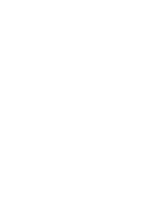


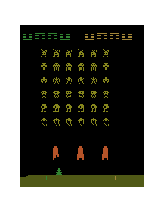
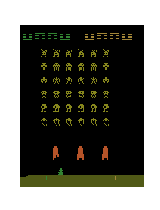
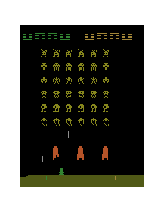
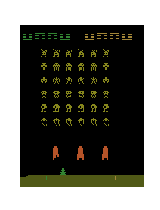
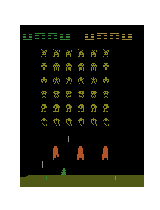
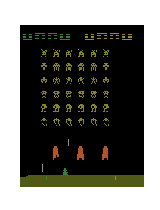
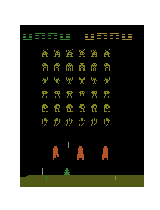
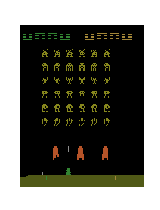
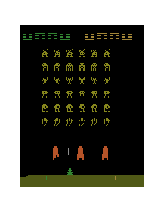
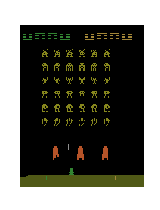
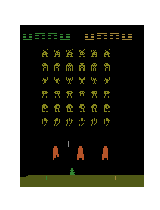
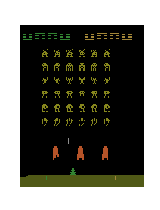
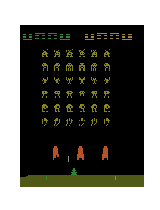
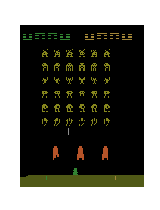
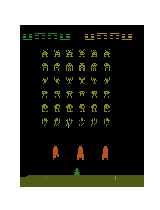
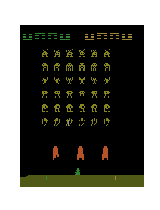
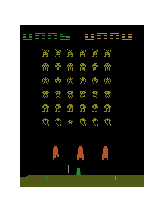
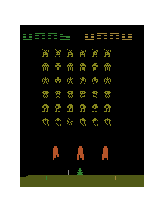
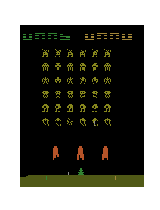
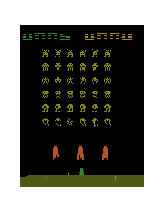
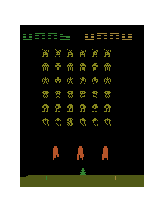
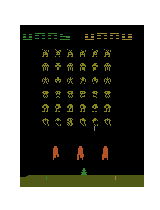
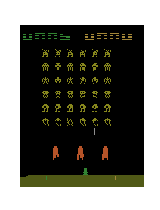
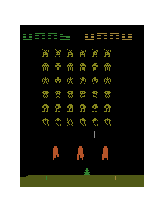
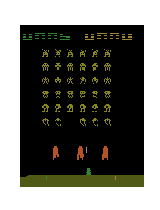
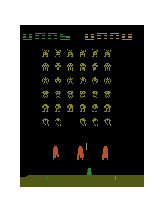
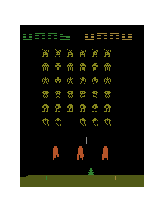
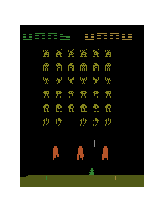
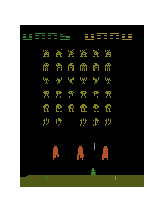
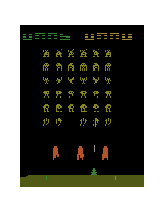
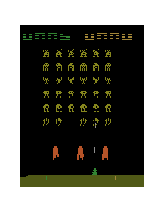
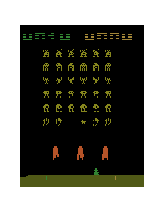
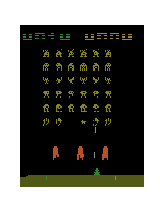
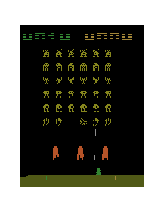
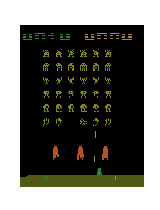
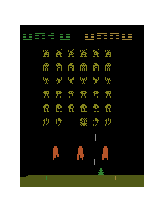
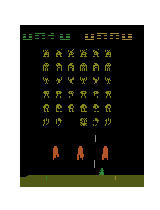
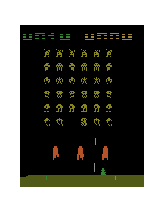
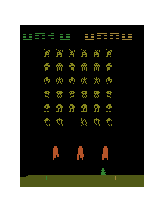
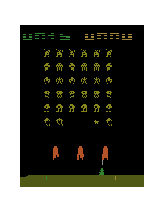
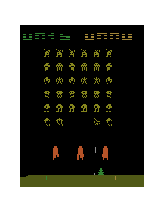
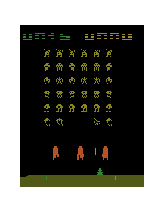
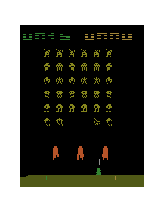
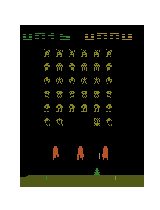
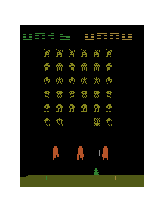
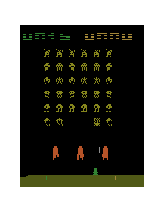
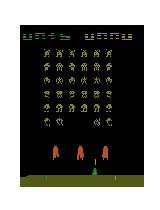
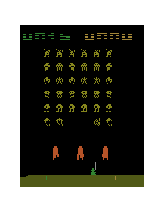
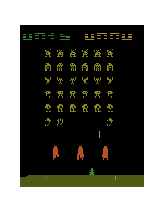
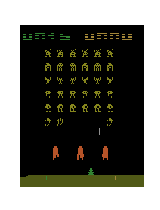
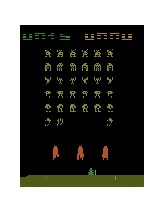
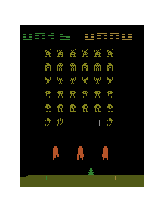
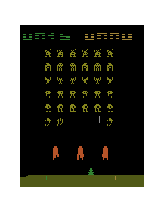
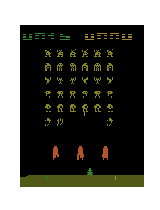
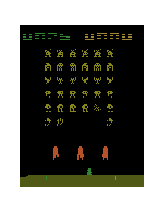
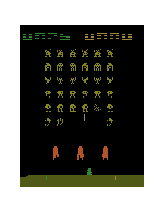
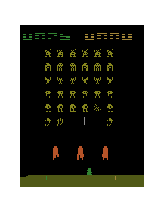
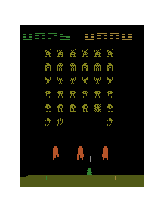
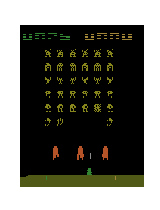
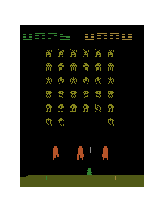
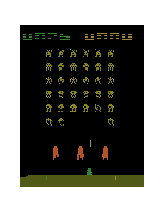
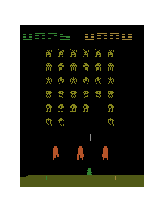
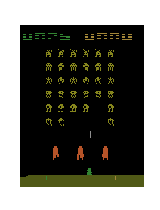
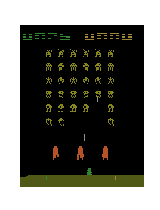
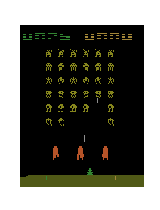
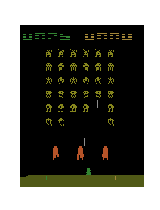
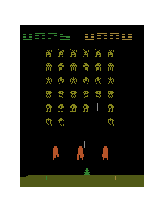
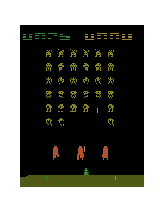
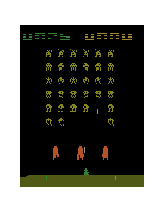
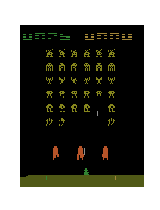
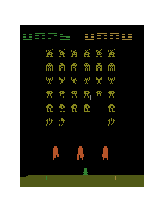
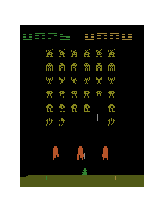
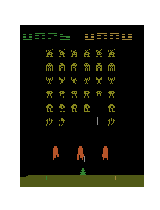
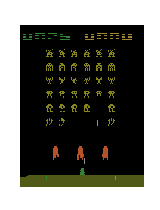
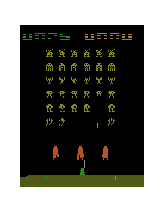
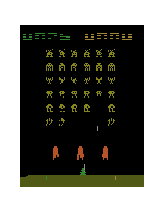
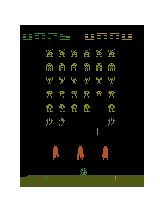
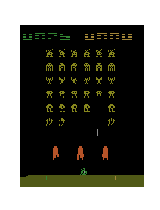
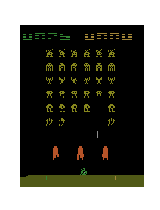
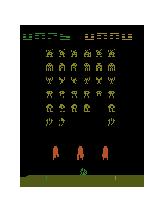
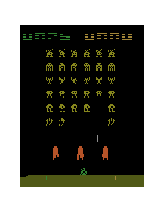
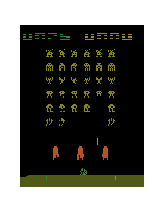
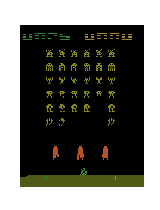
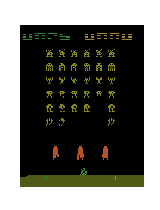
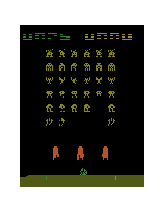
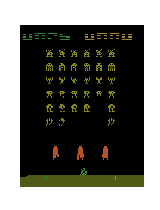
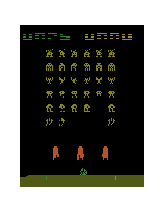
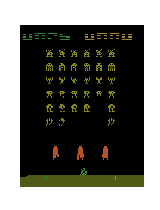
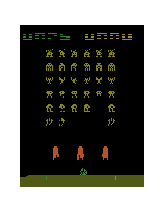
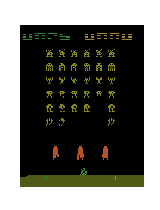
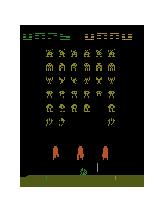
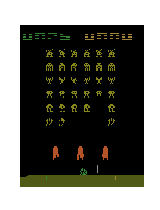
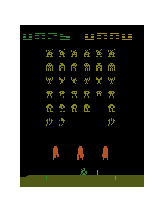
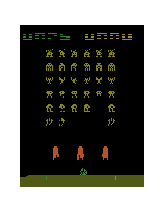
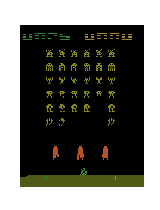
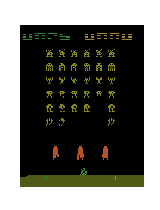
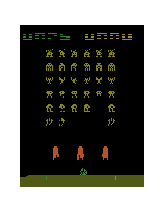
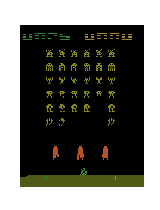
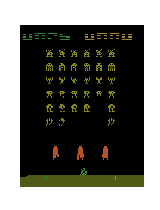
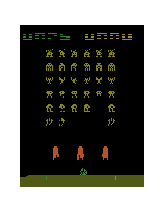
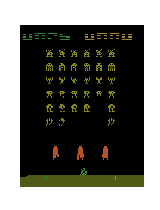
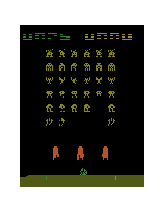
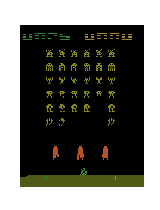
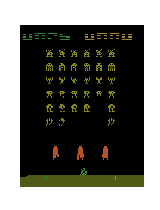
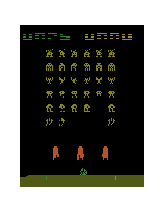
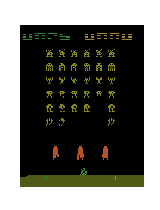
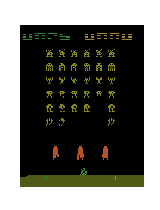
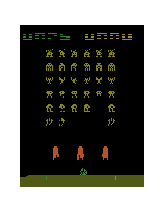
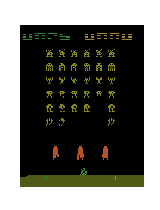
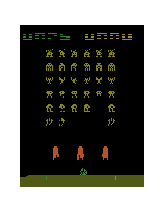
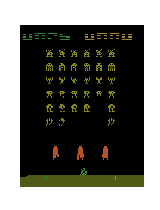
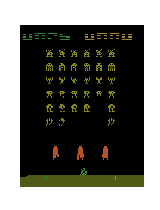
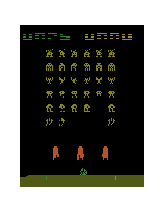
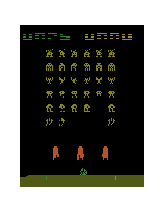
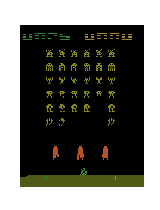
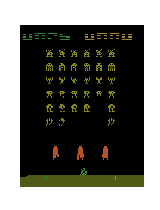
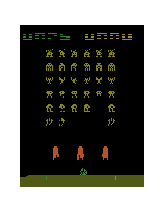
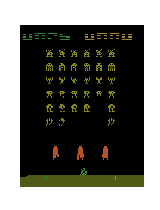
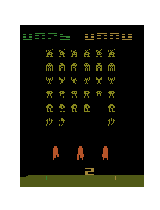
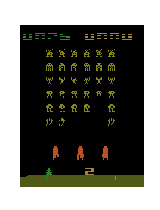
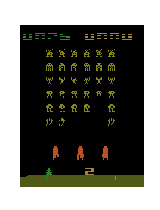
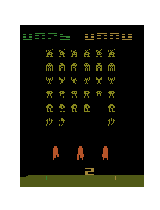
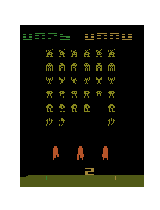
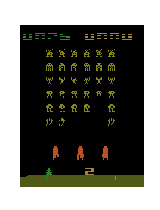
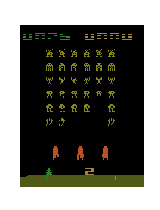
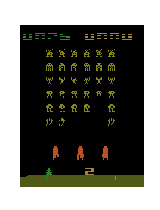
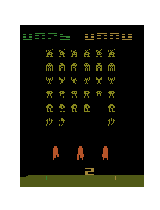
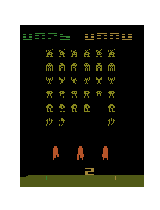
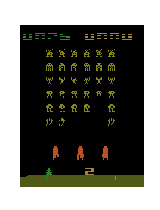
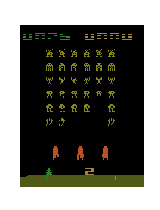
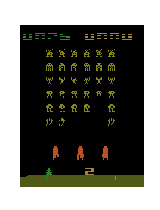
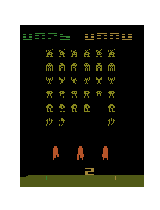
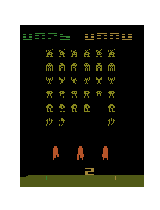
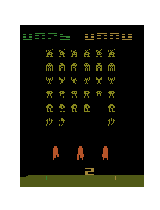
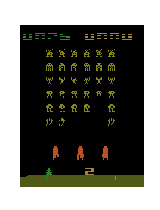
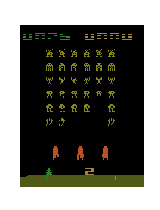
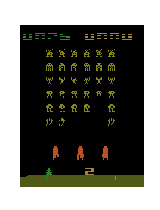
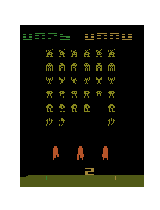
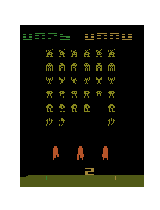
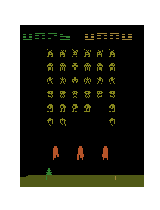
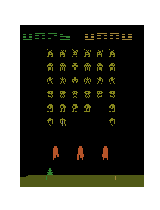
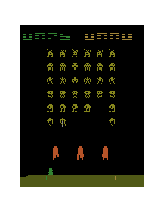
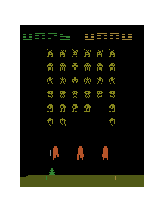
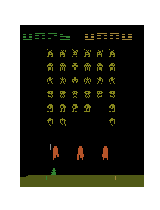
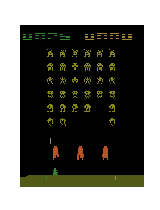
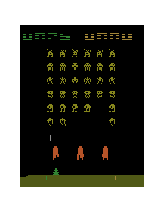
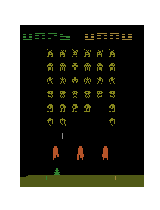
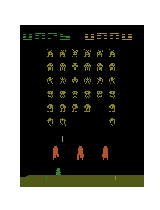
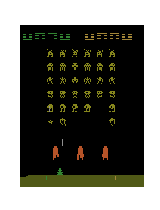
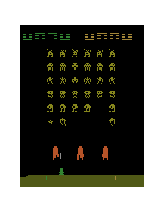
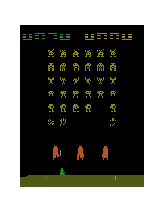
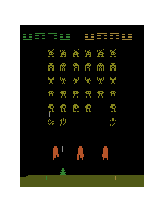
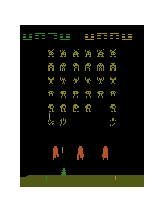
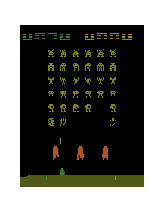
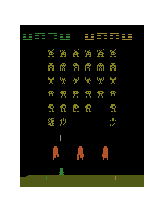
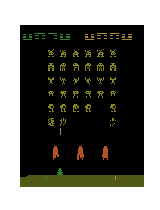
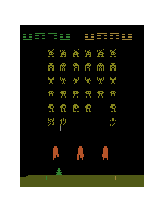
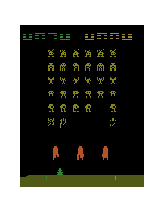
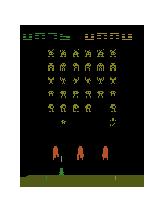
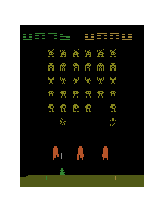
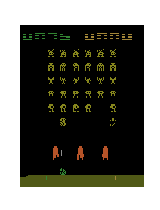
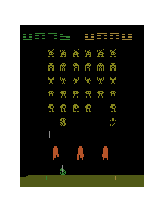
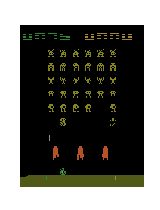
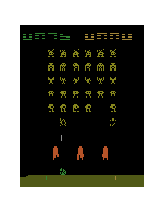
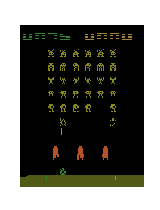
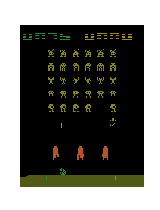
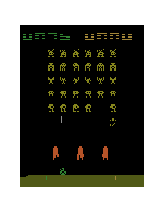
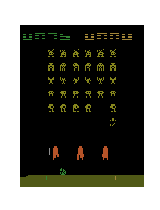
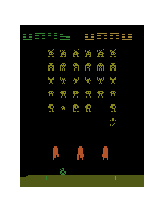
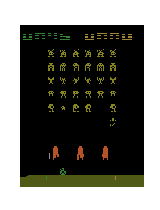
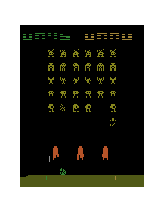
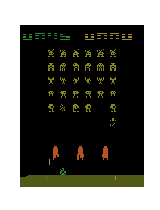
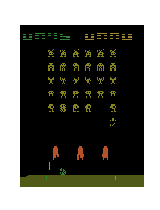
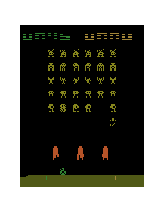
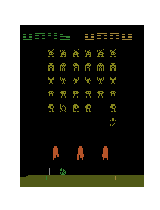
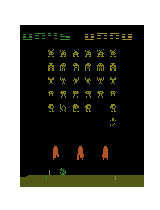
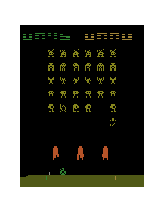
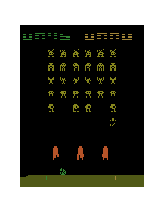
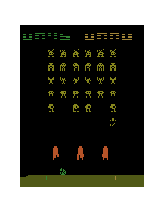
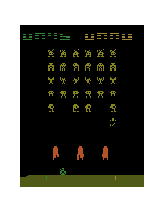
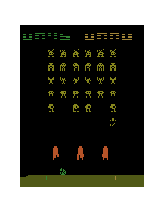
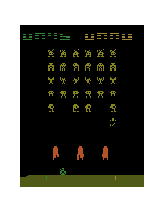
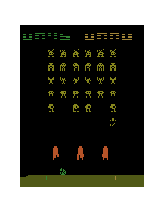
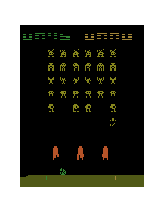
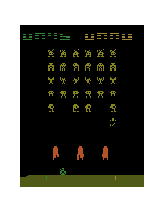
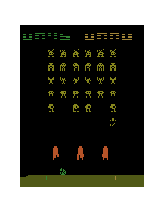
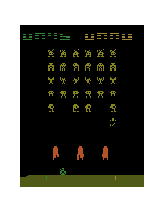
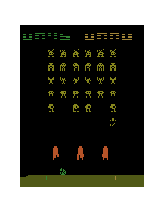
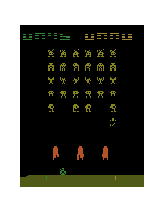
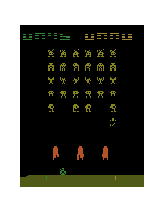
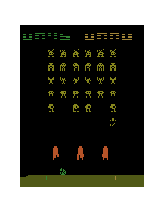
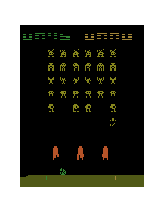
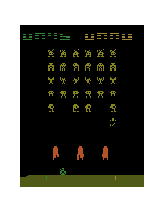
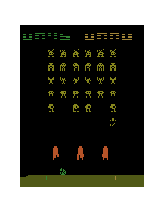
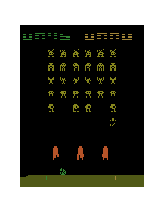
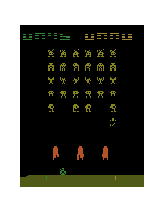
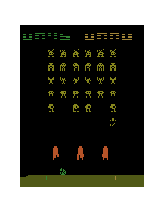
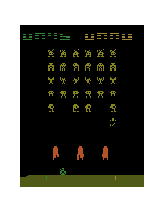
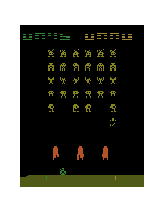
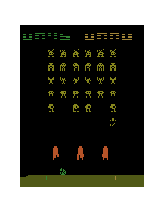
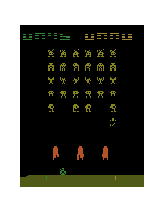
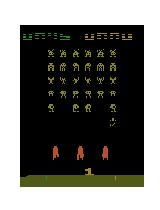
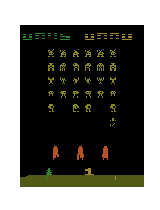
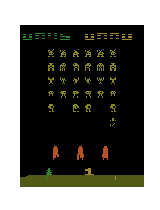
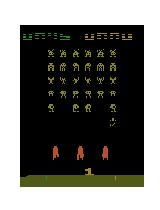
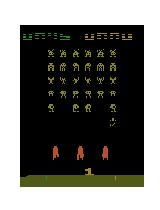
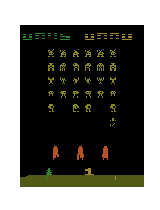
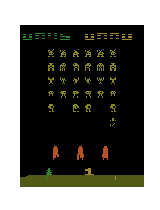
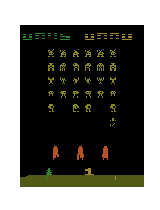
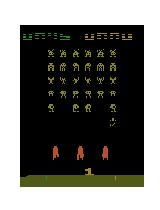
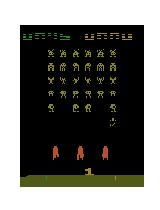
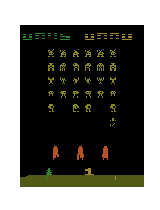
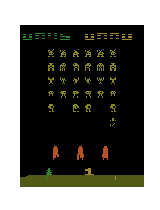
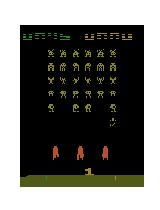
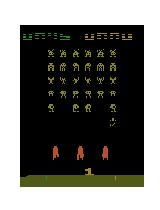
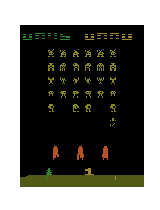
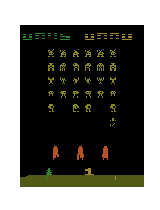
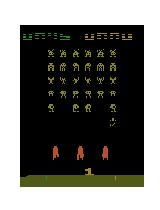
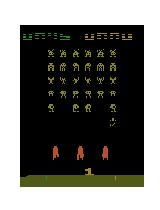
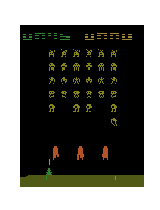
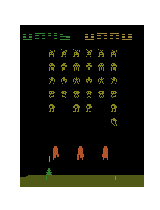
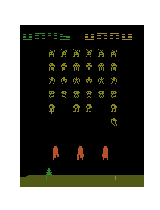
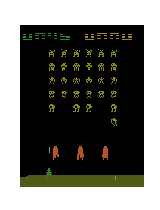
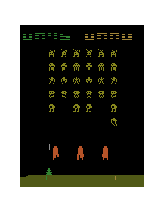
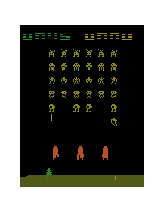
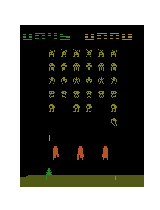
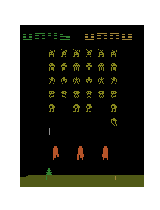
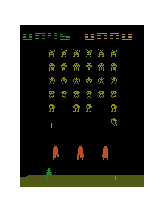
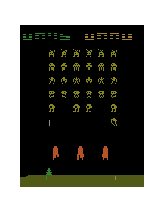
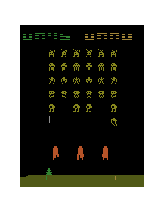
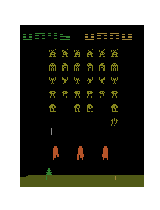
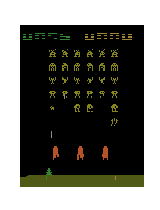
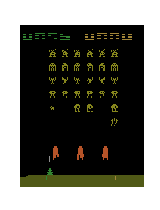
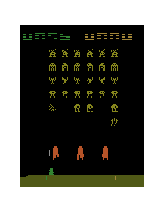
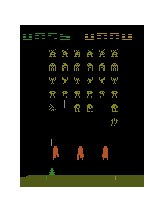
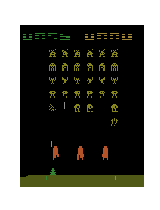
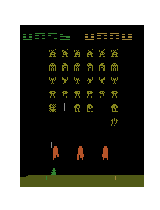
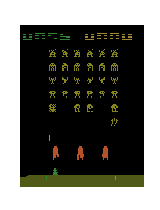
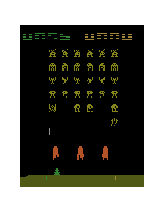
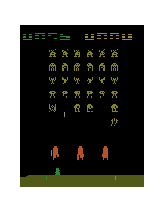
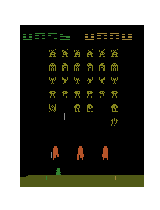
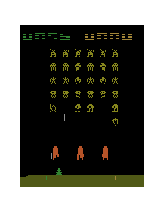
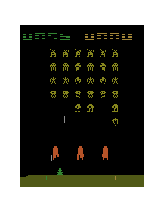
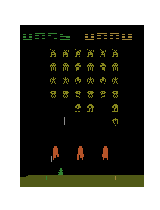
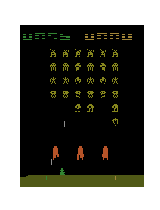
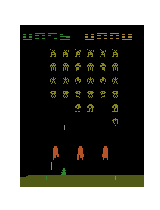
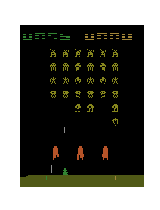
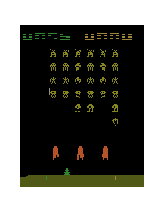
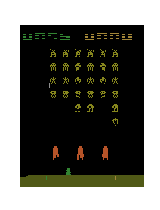
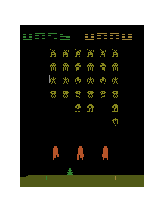
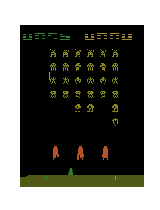
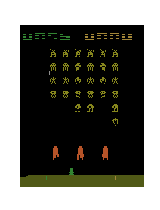
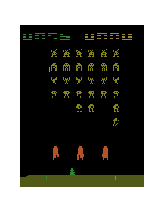
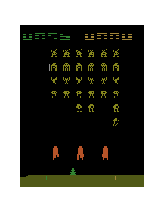
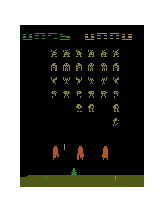
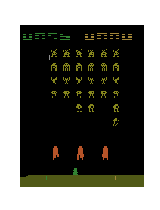
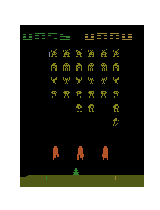
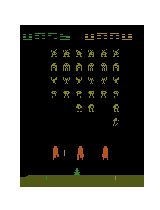
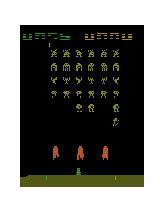
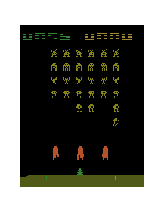
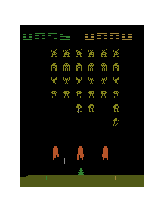
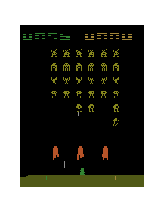
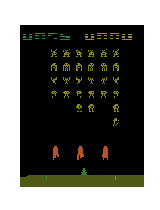
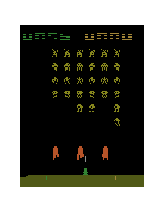
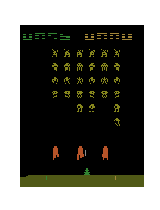
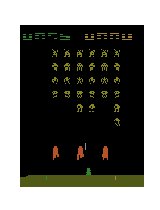
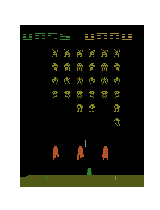
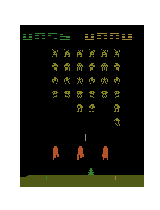
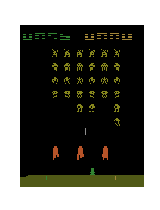
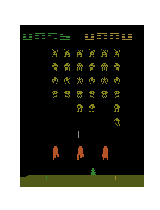
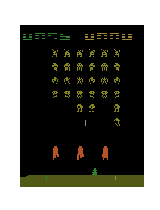
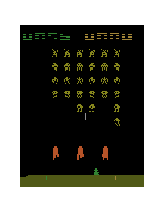
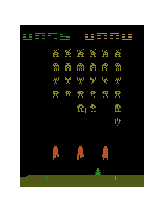
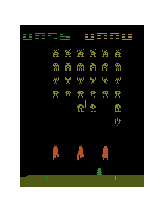
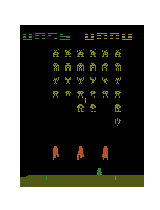
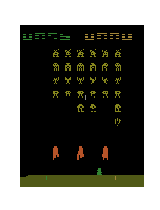
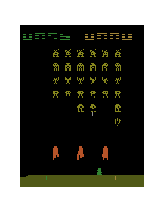
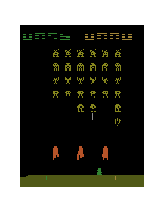
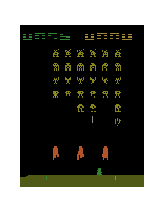
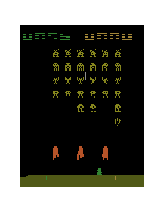
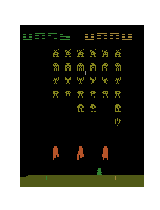
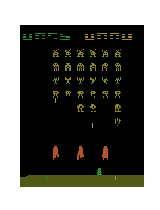
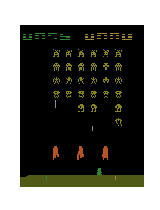
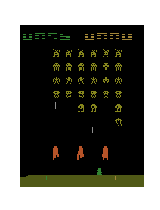
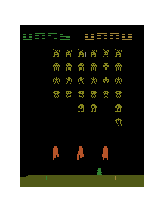
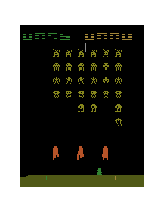
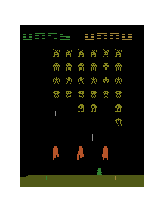
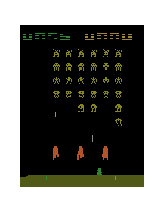
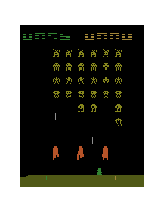
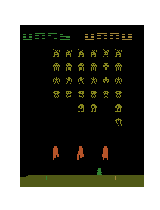
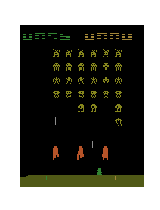
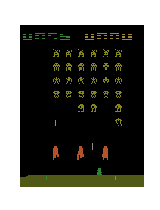
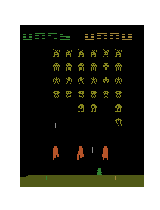
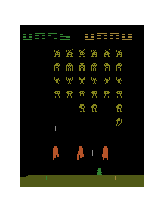
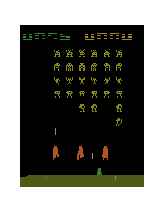
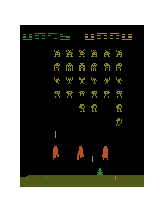
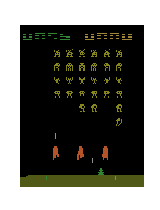
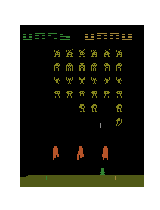
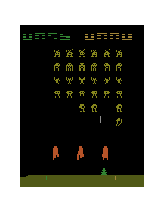
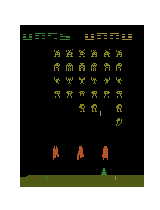
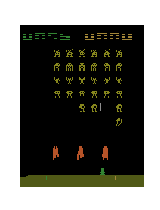
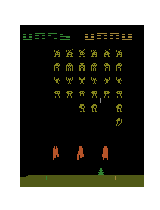
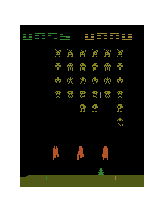
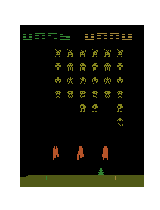
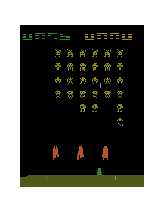
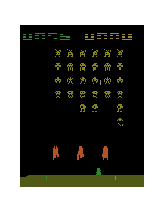
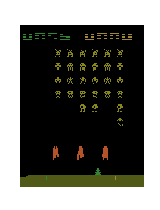
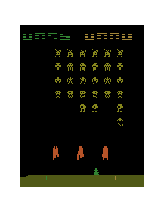
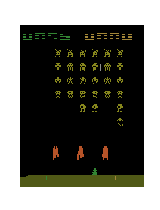
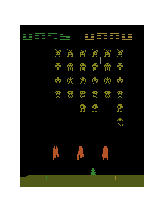
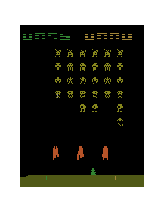
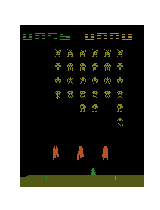
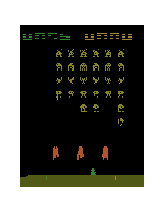
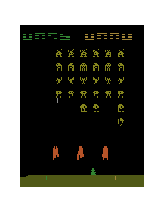
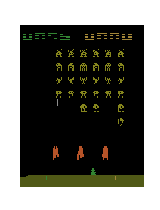
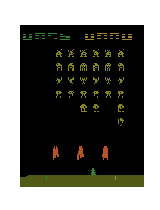
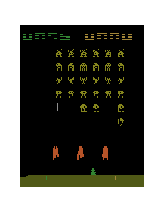
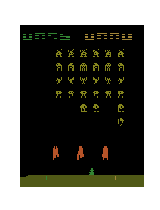
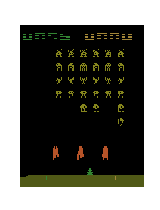
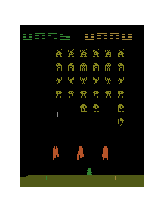
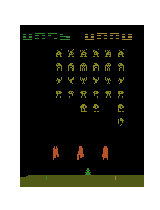
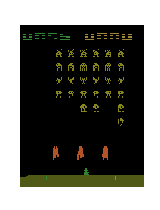
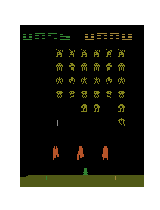
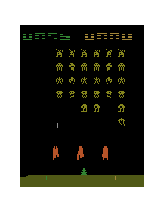
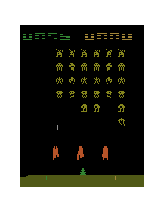
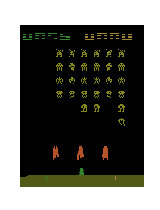
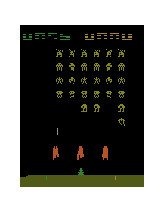
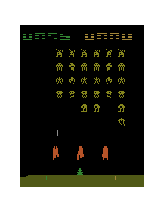
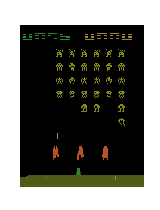
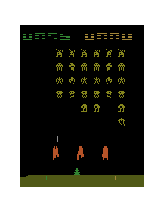
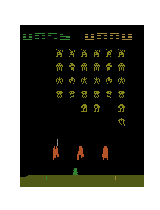
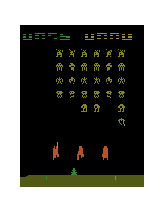
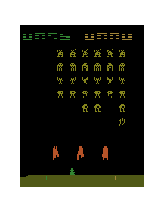
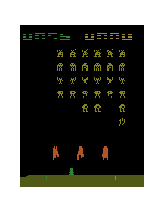
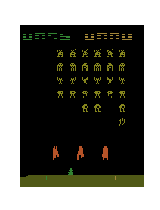
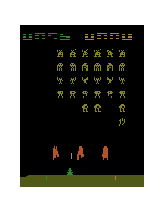
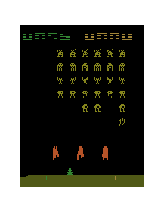
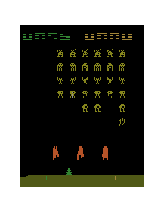
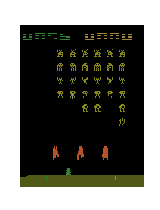
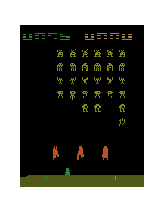
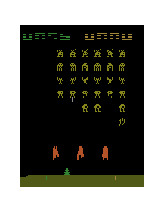
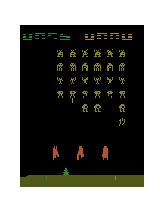
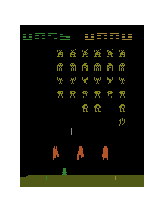
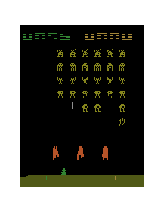
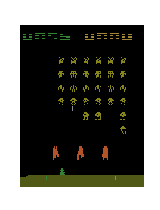
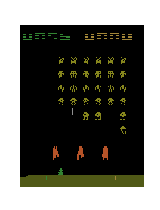
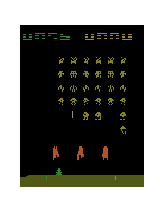
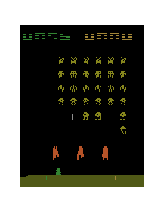
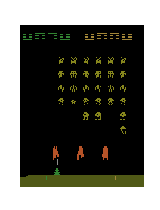
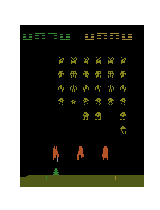
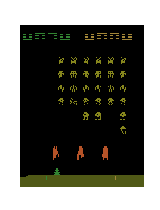
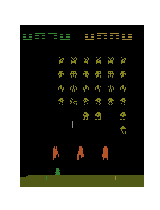
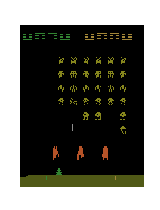
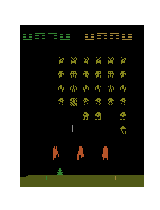
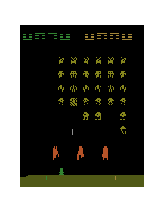
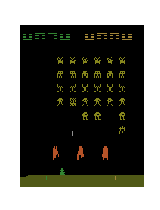
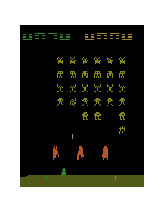
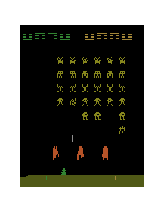
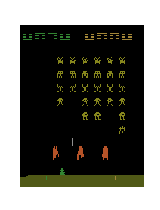
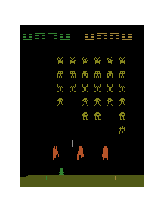
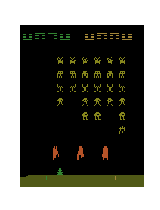
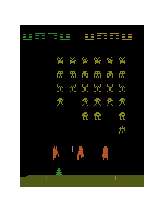
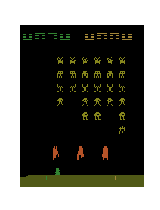
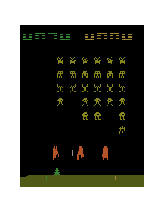
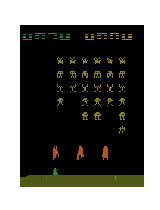
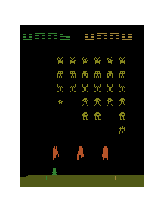
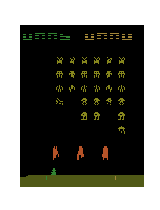
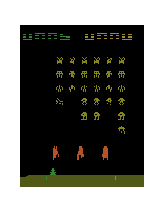
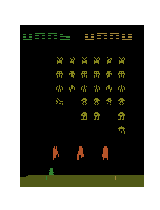
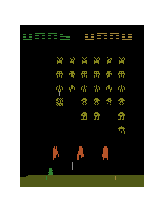
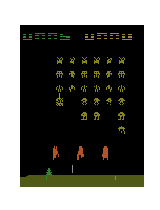
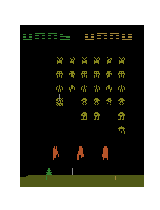
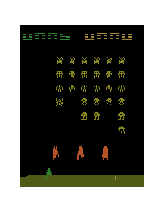
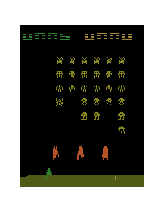
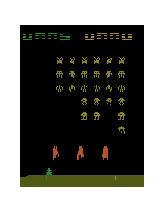
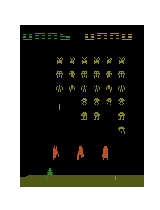
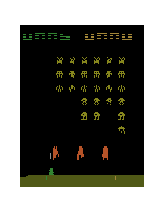
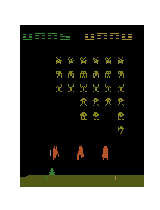
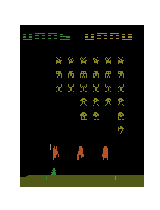
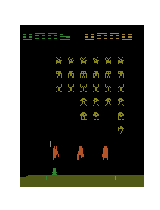
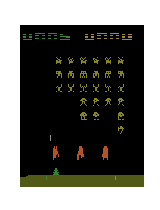
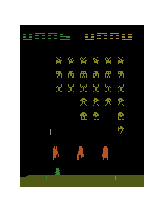
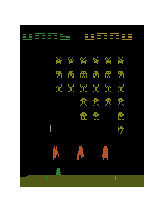
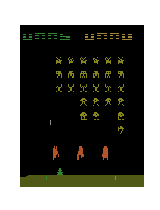
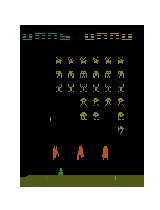
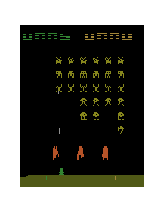
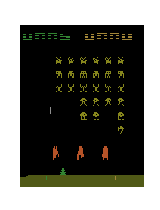
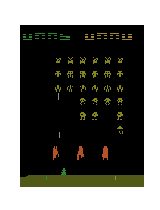
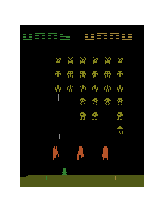
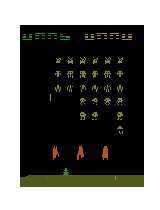
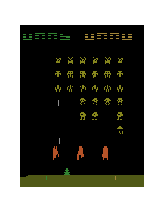
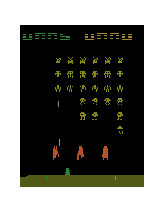
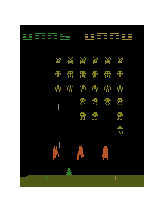
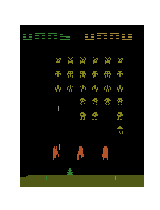
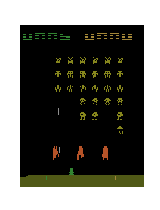
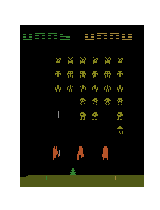
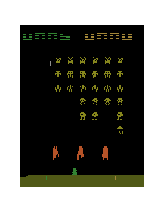
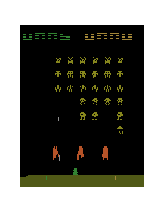
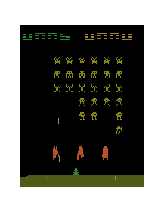
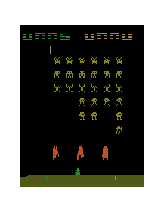
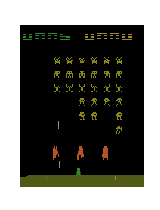
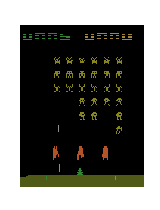
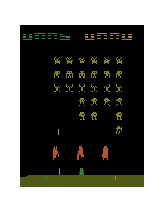
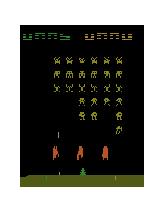
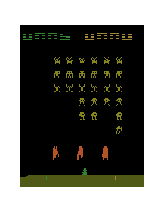
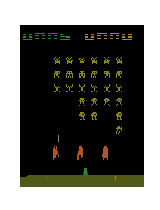
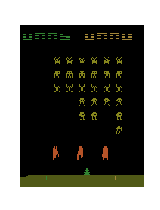
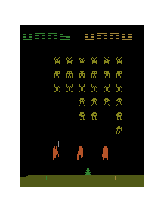
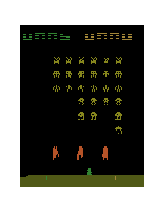
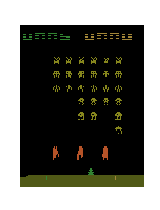
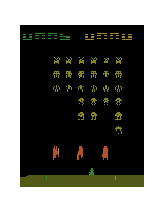
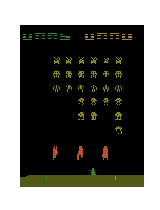
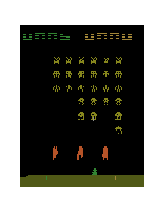
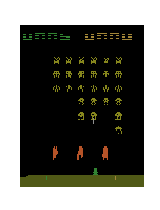
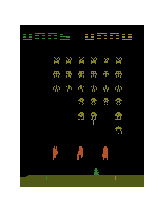
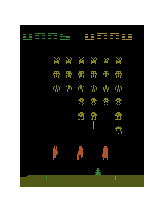
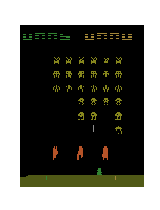
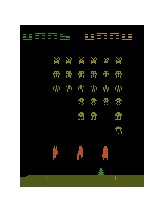
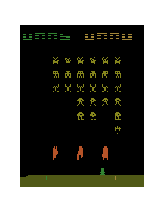
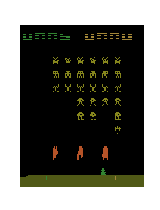
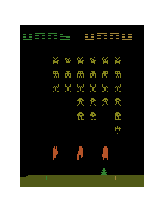
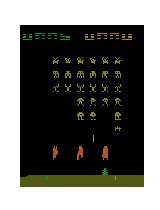
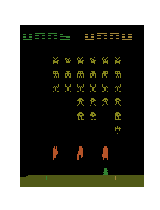
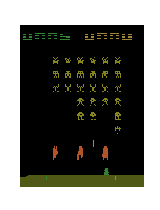
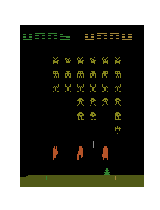
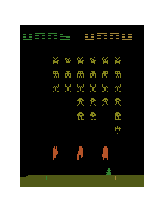
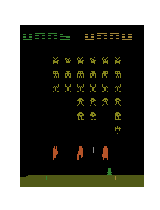
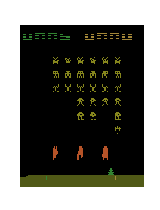
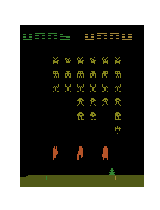
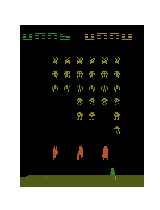
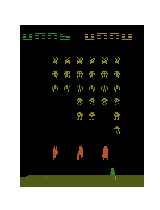
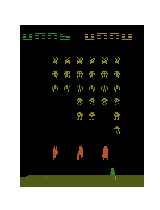
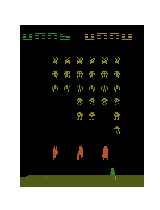
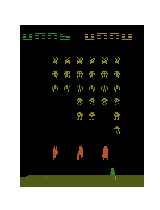
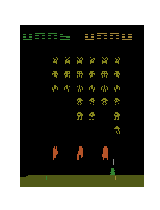
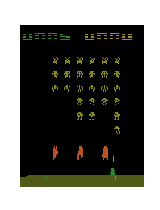
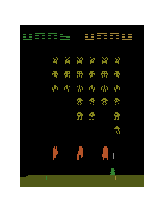
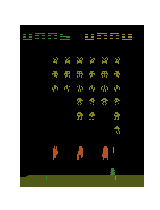
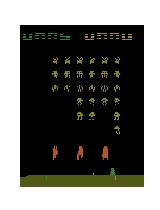
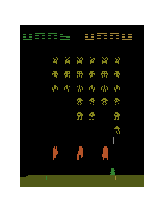
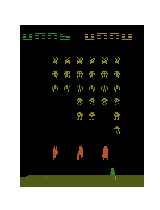
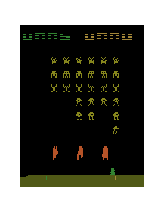
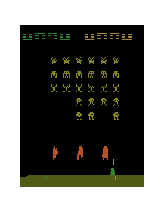
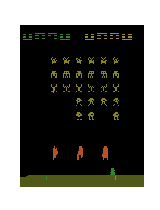
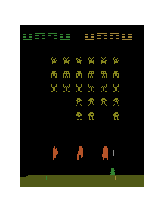
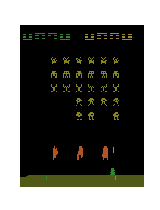
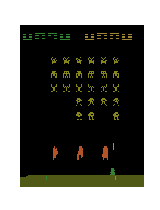
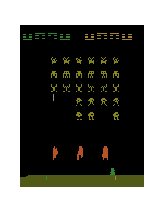
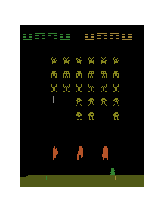
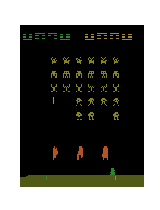

In [5]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    if len(frames) == 0:
        return
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))
    
    
frameshistory = []
backupepsilon = brain.epsilon

brain.epsilon = 0.0

for _ in range(450):
    action = brain.getAction()
    
    #print(action)
    actionmax = np.argmax(np.array(action))
    
    nextObservation,reward,terminal, info = env.step(actionmax)
    if terminal:
        nextObservation = env.reset()
    frameshistory.append(nextObservation)
    nextObservation = preprocess(nextObservation)
    brain.setPerception(nextObservation,action,reward,terminal)
brain.epsilon = backupepsilon
    
display_frames_as_gif(frameshistory)

In [ ]:
nextObservation[0].shape

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    if len(frames) == 0:
        return
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save('notworking.gif', writer = 'imagemagick', fps=30)

    display(display_animation(anim, default_mode='loop'))
display_frames_as_gif(frameshistory[0:175])